In [1]:
from openbb_terminal.sdk import openbb
from libs.backtester import Backtester
from backtesting import Strategy
from backtesting.lib import crossover
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

In [2]:
price_qqq = openbb.stocks.load('QQQ', start_date='2005-01-01', end_date='2007-01-01')
price_qqq.head()

Loading Daily data for QQQ with starting period 2005-01-03.

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
date,,,,,,,,
2005-01-03,34.530718,34.702985,33.910560,34.022533,34.022533,100970900,0.0,0.0
2005-01-04,34.168977,34.229273,33.204288,33.402393,33.402393,136623200,0.0,0.0
2005-01-05,33.316249,33.557421,33.135371,33.195663,33.195663,127925500,0.0,0.0
2005-01-06,33.273184,33.342088,33.023397,33.032009,33.032009,102934600,0.0,0.0
2005-01-07,33.212896,33.479906,32.911428,33.204281,33.204281,123104000,0.0,0.0


<Axes: xlabel='date'>

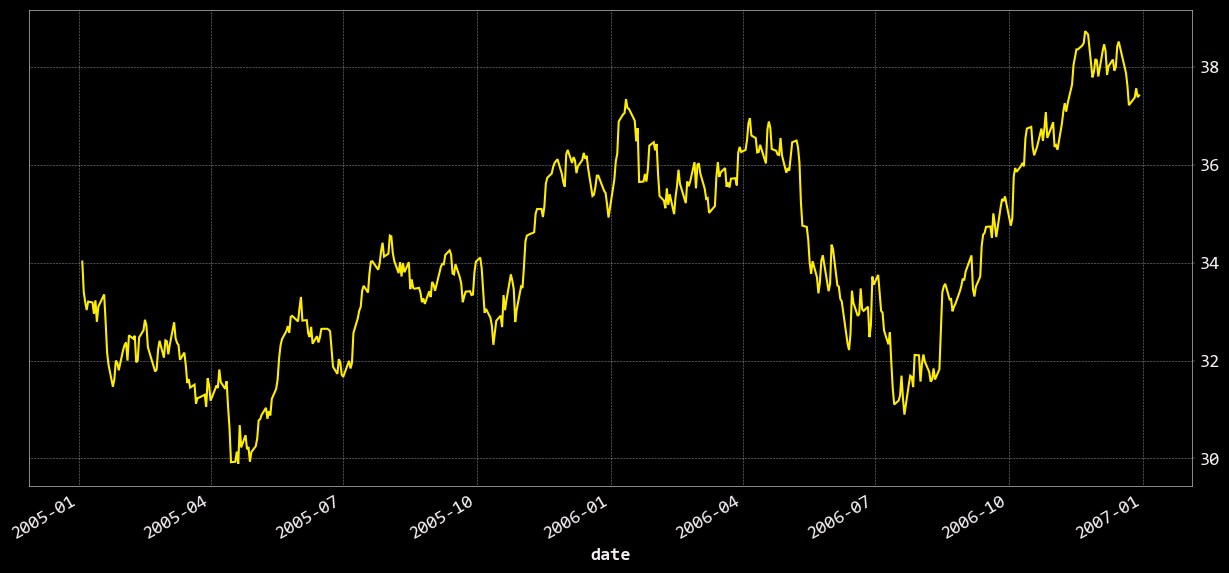

In [3]:
price_qqq['Close'].plot()

<Axes: xlabel='date'>

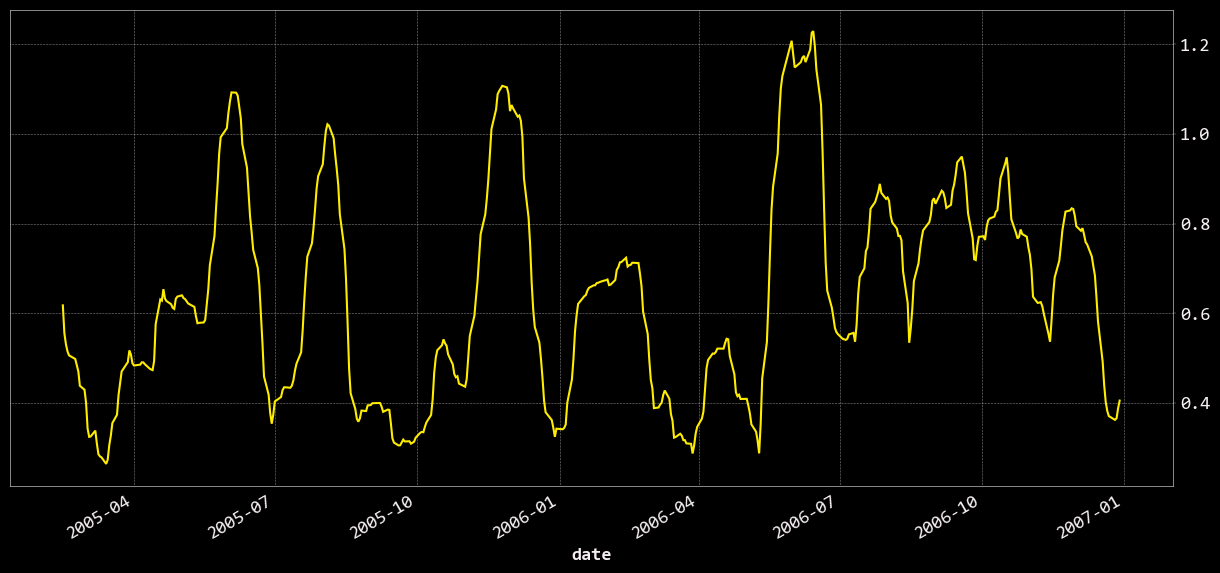

In [4]:
price_qqq['Close'].rolling(30).std().plot()

In [8]:
def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

def sharpe_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rolling_max = df['High'].rolling(window, min_periods=1).max()
    drawdown = (df['High']/rolling_max) - 1.0
    sharpe_drawdown = (sharpe * drawdown).apply(lambda v: v if v > 0 else 0)
    sharpe_drawdown_a = ta.sma(sharpe_drawdown, length=smoothing_a)
    sharpe_drawdown_b = ta.sma(sharpe_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_drawdown_a.values, sharpe_drawdown_b.values)
    # TODO: if past 5 days has signal go again
    # TODO: if past 10 days has trades closed due to Low price, and vwaps cross, go again
    

def _sharpe_rsi_drawdown(df, window):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rsi = ta.rsi(close=df['Close'], length=window)
    rolling_max = rsi.rolling(30, min_periods=1).max()
    rsi_drawdown = (rsi/rolling_max) - 1.0
    sharpe_rsi_drawdown = (sharpe * rsi_drawdown).apply(lambda v: v if v > 0 else 0)
    return sharpe_rsi_drawdown
    
def sharpe_rsi_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe_rsi_drawdown = _sharpe_rsi_drawdown(df=df, window=window)
    sharpe_rsi_drawdown_sma_a = ta.sma(sharpe_rsi_drawdown, length=smoothing_a)
    sharpe_rsi_drawdown_sma_b = ta.sma(sharpe_rsi_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_rsi_drawdown_sma_a.values, sharpe_rsi_drawdown_sma_b.values)

def rolling_stddev(df, window):
    return df['Close'].rolling(window).std()

def stoploss_line(df, window, tolerance):
    stddev = rolling_stddev(df, window)
    offset = (1.0 + tolerance) * stddev
    return df['Low'] - offset

def vwapma_line(df, length):
    vwap = ta.vwap(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
    return ta.sma(vwap, length=length)

class TQQQStrategy(Strategy):
    NAME = 'tqqq strategy'
    BUY_SIGNAL_THRESHOLD = 0.001
    STOPLOSS_TOLERANCE = 0.05
    
    def init(self):
        super().init()
        self.sharpe_drawdown_crossing = self.I(sharpe_rsi_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=10, smoothing_b=15)
        #self.b = self.I(sharpe_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=5, smoothing_b=15)
        # self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        # self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        self.vwma_5d = self.I(vwapma_line, df=self.data.df, length=5, overlay=True)
        self.vwma_20d = self.I(vwapma_line, df=self.data.df, length=10, overlay=True)
        self.stddev = self.I(rolling_stddev, df=self.data.df, window=30)
        self.stoploss = self.I(stoploss_line, df=self.data.df, window=30, tolerance=self.STOPLOSS_TOLERANCE, overlay=True)
        #self.roc = self.I(ta.roc, close=self.data.df['Close'], length=1)
        self.signal_count = 0
        
    def _signal_flag(self, flag, n=1):
        signal_off = not flag
        is_nth_signal = flag and self.signal_count == n
        return signal_off or is_nth_signal
    
    def _market_trading_down(self):
        vmwa_below = self.vwma_5d[-1] < self.vwma_20d[-1]
        open_below_vmwa = self.data.Open[-1] < self.vwma_5d[-1]
        close_below_vmwa = self.data.Close[-1] < self.vwma_5d[-1]
        return vmwa_below and close_below_vmwa #and open_below_vmwa
        
    def next(self):
        super().next()
        if self.position.size > 0:
            for trades in self.trades:
                trade_stoploss = trades.sl
                stoploss_t0 = self.stoploss[-1]
                trades.sl = max(trade_stoploss, stoploss_t0)
            
        signal = self.sharpe_drawdown_crossing[-1]
        max_signal_past_20d = max(self.sharpe_drawdown_crossing[-5:-1]) # past 10 days
        signal_memory_condition = False#not self._market_trading_down() and max_signal_past_20d >= self.BUY_SIGNAL_THRESHOLD > 0
        has_signal = signal >= self.BUY_SIGNAL_THRESHOLD or (self.position.size == 0 and signal_memory_condition)
        if has_signal:
            self.signal_count += 1
            if self._signal_flag(False):
                sl = self.stoploss[-1]
                self.buy(sl=sl, size=0.4)
            
            
#bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('TQQQ', start_date='2010-01-01', end_date='2012-01-01'), capital=10000, commission=0.002)
bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('QQQ', start_date='1995-01-01', end_date='2005-01-01'), capital=10000, commission=0.002)
bt.run()


Loading Daily data for QQQ with starting period 1999-03-10.

Start                     1999-03-10 00:00:00
End                       2004-12-31 00:00:00
Duration                   2123 days 00:00:00
Exposure Time [%]                   33.356118
Equity Final [$]                  8686.631391
Equity Peak [$]                  11561.693662
Return [%]                         -13.133686
Buy & Hold Return [%]              -21.041675
Return (Ann.) [%]                   -2.396088
Volatility (Ann.) [%]                 8.85432
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.235414
Avg. Drawdown [%]                   -3.177234
Max. Drawdown Duration     1824 days 00:00:00
Avg. Drawdown Duration      168 days 00:00:00
# Trades                                   43
Win Rate [%]                        37.209302
Best Trade [%]                      29.508747
Worst Trade [%]                    -14.328736
Avg. Trade [%]                    

In [14]:
class TQQQBasicMeanReverseStrategy(Strategy):
    NAME = 'tqqq strategy basic mean reversion'
    
    def init(self):
        super().init()
        
    def next(self):
        super().next()
        if self.data.Close[-1] < self.data.Close[-2]:
            self.buy(size=0.01)
        if self.data.Close[-1] > self.data.Close[-2]:
            self.position.close()
            #self.sell(size=1)
                
                
bt = Backtester(strategy=TQQQBasicMeanReverseStrategy, data=openbb.stocks.load('QQQ', start_date='1995-01-01', end_date='2005-01-01'), capital=100_000, commission=0.00)
bt.run()

Loading Daily data for QQQ with starting period 1999-03-10.

Start                     1999-03-10 00:00:00
End                       2004-12-31 00:00:00
Duration                   2123 days 00:00:00
Exposure Time [%]                     73.4108
Equity Final [$]                 10041.866918
Equity Peak [$]                   10069.30507
Return [%]                           0.418669
Buy & Hold Return [%]              -21.041675
Return (Ann.) [%]                    0.071991
Volatility (Ann.) [%]                0.253583
Sharpe Ratio                         0.283893
Sortino Ratio                         0.42009
Calmar Ratio                         0.110671
Max. Drawdown [%]                   -0.650491
Avg. Drawdown [%]                   -0.057594
Max. Drawdown Duration     1558 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                  698
Win Rate [%]                        52.148997
Best Trade [%]                      18.083845
Worst Trade [%]                     -10.88584
Avg. Trade [%]                    

<Axes: xlabel='date'>

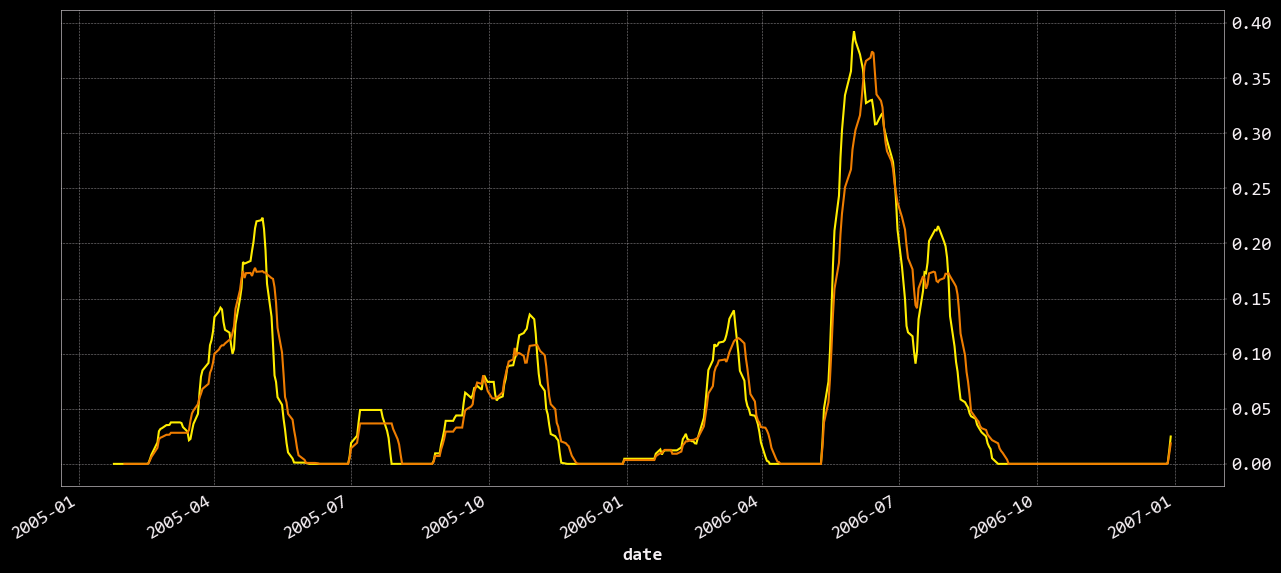

In [6]:
ta.sma(_sharpe_rsi_drawdown(price_qqq, 30), 15).plot()
ta.sma(_sharpe_rsi_drawdown(price_qqq, 30), 20).plot()